In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 835.8 kB/s eta 0:00:000:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


Number of invalid paths: 0
Found 357 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Epoch 1/50


/Users/andreshofmann/.pyenv/versions/3.12.2/envs/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4620 - loss: 1.9787 - val_accuracy: 0.5889 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5259 - loss: 1.0140 - val_accuracy: 0.5889 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5779 - loss: 0.8542 - val_accuracy: 0.5889 - val_loss: 0.6781 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5622 - loss: 0.8146 - val_accuracy: 0.5889 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5481 - loss: 0.7097 - val_accuracy: 0.5889 - val_loss: 0.8024 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5318 - loss: 0.8399 - val_accuracy: 0.5889 - val_loss: 0.9354 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4856 - loss: 0.9862 - val_accuracy: 0.5889 - va

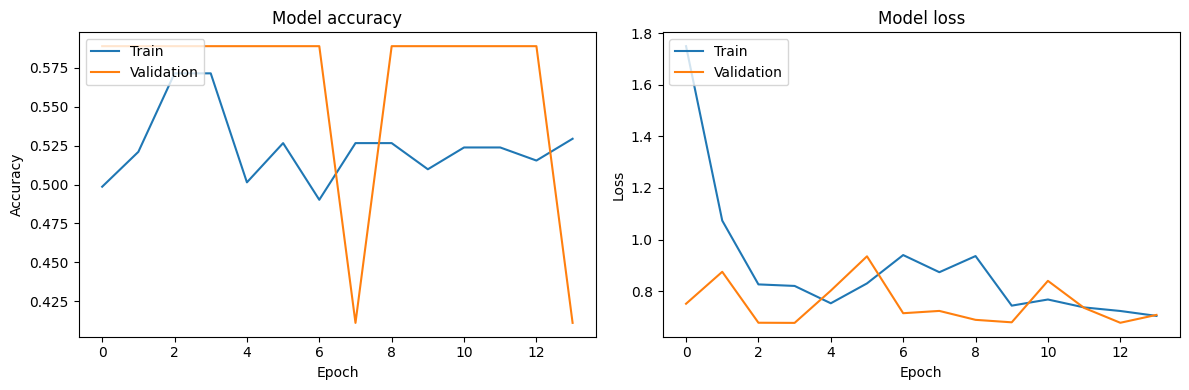

Evaluating images: 100%|██████████| 90/90 [00:06<00:00, 14.87it/s]


Validation accuracy: 0.5888888888888889
Final prediction for image ISIC_0028965: 0.57703686


In [5]:
import json
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, LayerNormalization, Conv2D, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from einops.layers.tensorflow import Rearrange

# Load the configuration file
with open('/Users/andreshofmann/Desktop/Studies/Uol/7t/FP/fp_legonet/research/code/CNN/config_v11_data_sub_set_cnn.json', 'r') as config_file:
    config = json.load(config_file)

# Paths
base_dir = config['paths']['base_dir']
csv_path = config['paths']['csv_path']
img_dir = config['paths']['img_dir']
model_save_path = config['paths']['model_save_path']

# Training parameters
validation_split = config['training']['validation_split']
fraction = config['training']['fraction']
sample_fraction = config['training'].get('sample_fraction', 1.0)  # Default to 1.0 if not specified
batch_size = config['training']['batch_size']
epochs = config['training']['epochs']
initial_learning_rate = config['training']['initial_learning_rate']
learning_rate_decay = config['training']['learning_rate_decay']
patience = config['training']['patience']
reduce_lr_factor = config['training']['reduce_lr_factor']
reduce_lr_patience = config['training']['reduce_lr_patience']
min_lr = config['training']['min_lr']

# Data augmentation parameters
data_aug_params = config['data_augmentation']

# Load the CSV file
data = pd.read_csv(csv_path)

# Function to extract patch number from Patch_id
def get_patch_folder(patch_id):
    parts = patch_id.split('_')
    patch_num = parts[-1].split('.')[0]  # Extract patch number
    return f'Patch_{patch_num}'

# Debugging version of get_full_path
def get_full_path(row):
    try:
        patch_folder = get_patch_folder(row['Patch_id'])
        if row['label'] == 1:
            full_path = os.path.join(img_dir, 'mel_patches', patch_folder, row['Patch_id'])
        else:
            full_path = os.path.join(img_dir, 'bkl_patches', patch_folder, row['Patch_id'])

        if not os.path.exists(full_path):
            print(f"Invalid path: {full_path}")

        return full_path
    except Exception as e:
        print(f"Error processing row: {row}")
        print(f"Error message: {str(e)}")
        return None

# Apply the function to add the full path
data['path'] = data.apply(get_full_path, axis=1)

# Check for invalid paths and remove them
data['path_exists'] = data['path'].apply(os.path.exists)
invalid_paths = data[~data['path_exists']]
print(f"Number of invalid paths: {len(invalid_paths)}")
if not invalid_paths.empty:
    print(invalid_paths.head())
data = data[data['path_exists']]

# Convert label column to string
data['label'] = data['label'].astype(str)

# Sample a fraction of the data
sampled_data = data.sample(frac=sample_fraction, random_state=42)

# Split the data into training and validation sets
train_data, val_data = train_test_split(sampled_data, test_size=validation_split, stratify=sampled_data['label'], random_state=42)

# Image data generator for augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=data_aug_params['rescale'],
    rotation_range=data_aug_params['rotation_range'],
    width_shift_range=data_aug_params['width_shift_range'],
    height_shift_range=data_aug_params['height_shift_range'],
    shear_range=data_aug_params['shear_range'],
    zoom_range=data_aug_params['zoom_range'],
    horizontal_flip=data_aug_params['horizontal_flip'],
    vertical_flip=data_aug_params['vertical_flip'],
    brightness_range=data_aug_params['brightness_range']
)

val_datagen = ImageDataGenerator(rescale=data_aug_params['rescale'])

# Create training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

# Define the CvT block
def cvt_block(x, filters, num_heads, mlp_dim, dropout=0.1):
    # Convolutional Projection
    x_proj = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x_proj = LayerNormalization(epsilon=1e-6)(x_proj)
    x_proj = Rearrange('b h w c -> b (h w) c')(x_proj)

    # Multi-head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=filters)(x_proj, x_proj)
    attn_output = Dropout(dropout)(attn_output)
    attn_output = Add()([x_proj, attn_output])

    # MLP Block
    mlp_output = Dense(mlp_dim, activation='relu')(attn_output)
    mlp_output = Dropout(dropout)(mlp_output)
    mlp_output = Dense(filters)(mlp_output)
    x = Add()([attn_output, mlp_output])

    # Rearrange back to image grid
    x = Rearrange('b (h w) c -> b h w c', h=int(tf.math.sqrt(tf.cast(x.shape[1], tf.float32))))(x)
    return x

# Build the CvT model
def build_cvt(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # CvT Blocks
    for filters, num_heads, mlp_dim in [(64, 4, 128), (128, 8, 256), (256, 16, 512)]:
        x = cvt_block(x, filters, num_heads, mlp_dim)

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(mlp_dim, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (64, 64, 3)
num_classes = 1

model = build_cvt(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=min_lr)

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

# Save the model
model.save(model_save_path)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Define a function to pool predictions from the 16 patches to produce a final prediction for the full image
def predict_full_image(image_id, model, data):
    patches = data[data['image_id'] == image_id]['path'].values
    predictions = []

    for patch in patches:
        img = load_img(patch, target_size=(64, 64))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        prediction = model.predict(img_array, verbose=0)
        predictions.append(prediction[0][0])

    return np.mean(predictions)

# Evaluate the model on the validation set
val_predictions = []
val_labels = []

for image_id in tqdm(val_data['image_id'].unique(), desc='Evaluating images'):
    label = val_data[val_data['image_id'] == image_id]['label'].values[0]
    val_labels.append(int(label))
    final_prediction = predict_full_image(image_id, model, val_data)
    val_predictions.append(final_prediction)

# Convert predictions to binary class (0 or 1)
val_predictions_binary = [1 if pred >= 0.5 else 0 for pred in val_predictions]

# Calculate accuracy
accuracy = np.mean(np.array(val_predictions_binary) == np.array(val_labels))
print('Validation accuracy:', accuracy)

# Example usage for a single image prediction
image_id = 'ISIC_0028965'
final_prediction = predict_full_image(image_id, model, data)
print(f'Final prediction for image {image_id}:', final_prediction)